# Merge of catalogs from DJA and SE++

This notebook merges the catalogs from SourceXtractor++ (Sersic and Bulge+Disk models) with the catalogs from the DJA (aperture photometry and photo-z).

In [39]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.table import Table, hstack, vstack, MaskedColumn
import astropy.units as u
import dja_sepp
from dja_sepp.utils import color_dict, channel_color_dict, channel_dict

plt.rcParams['xtick.labelsize']='large'
plt.rcParams['ytick.labelsize']='large'
plt.rcParams['axes.labelsize']='x-large'
plt.rcParams['legend.fontsize']='large'
plt.rcParams['xtick.top']=True
plt.rcParams['ytick.right']=True
plt.rcParams['xtick.direction']='in'
plt.rcParams['ytick.direction']='in'
plt.rcParams['xtick.minor.visible']=True
plt.rcParams['ytick.minor.visible']=True
# %matplotlib ipympl

First, we load the DJA and SE++ catalogs.

In [40]:
home = "/home/aurelien/DAWN/DJA-SEpp"
field = 'ceers-full-grizli-v7.2'
with fits.open(glob.glob(f"{home}/fields/{field}/catalog/dja/*fix_phot_apcorr.fits")[0]) as hdul:
    phot_dja = Table(hdul[1].data)
with fits.open(glob.glob(f"{home}/fields/{field}/catalog/dja/*zout.fits")[0]) as hdul:
    phot_z_dja = Table(hdul[1].data)
with fits.open(glob.glob(f"{home}/fields/{field}/sepp/sersic_rg4/*sci_tile-full_sepp_cat.fits")[0]) as hdul:
    phot_sersic = Table(hdul[1].data)
with fits.open(glob.glob(f"{home}/fields/{field}/sepp/B+D/*sci_tile-full_sepp_cat.fits")[0]) as hdul:
    phot_BD = Table(hdul[1].data)

We compare the number of sources in each catalog :
* Complete DJA catalog
* Complete SE++ catalog
* Cutout of the DJA catalog with the same footprint as the SE++ catalog

In [41]:
print(f"Sources in DJA photometry catalog   : {len(phot_dja)}")
print(f"Sources in DJA photo-z catalog      : {len(phot_z_dja)}")
print(f"Sources in Sersic catalog           : {len(phot_sersic)}")
print(f"Sources in B+D catalog              : {len(phot_BD)}")

Sources in DJA photometry catalog   : 76637
Sources in DJA photo-z catalog      : 76637
Sources in Sersic catalog           : 340554
Sources in B+D catalog              : 340627


We do a scatter plot of all the sources to visually see the footprint of the catalogs.

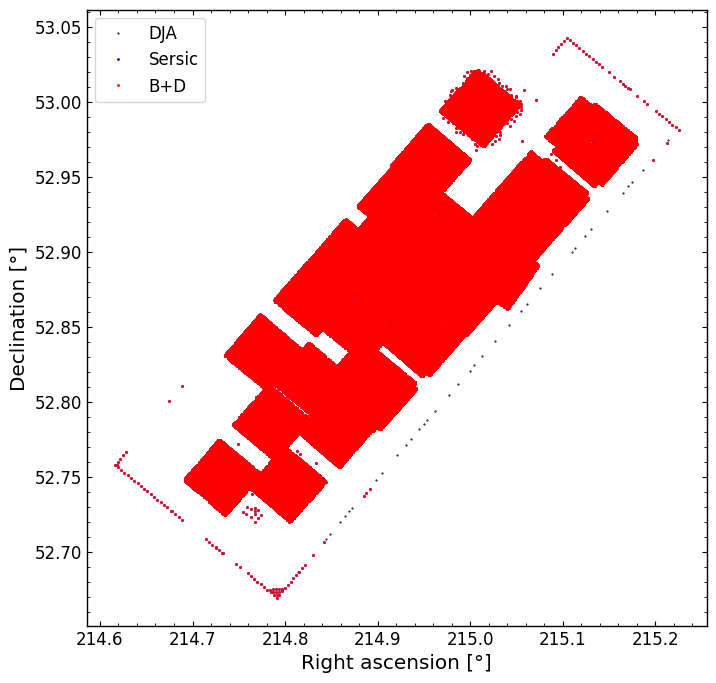

In [42]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(phot_dja['ra'], phot_dja['dec'], marker='o', ls='', ms=0.5, c='k', label='DJA')
ax.plot(phot_sersic['world_centroid_alpha'], phot_sersic['world_centroid_delta'], marker='o', ls='', ms=1, c='b', label='Sersic')
ax.plot(phot_BD['world_centroid_alpha'], phot_BD['world_centroid_delta'], marker='o', ls='', ms=1, c='r', label='B+D')
ax.set_xlabel('Right ascension [°]')
ax.set_ylabel('Declination [°]')
# ax.set_xlim(214.88, 214.95)
# ax.set_ylim(52.83, 52.88)
ax.legend()
plt.show()

We first cross-match the two SE++ catalogs with the DJA to compare them later...

In [43]:
coord_dja = SkyCoord(phot_dja['ra']*u.degree, phot_dja['dec']*u.degree)
coord_sersic = SkyCoord(phot_sersic['world_centroid_alpha']*u.degree, phot_sersic['world_centroid_delta']*u.degree)
coord_BD = SkyCoord(phot_BD['world_centroid_alpha']*u.degree, phot_BD['world_centroid_delta']*u.degree)
idx_sersic, d2d_sersic, _ = coord_sersic.match_to_catalog_sky(coord_dja)
idx_BD, d2d_BD, _ = coord_BD.match_to_catalog_sky(coord_dja)

... and we remove the matches further than `max_sep`.

Matched sources (Sersic) : 66559
Matched sources (B+D) : 66553


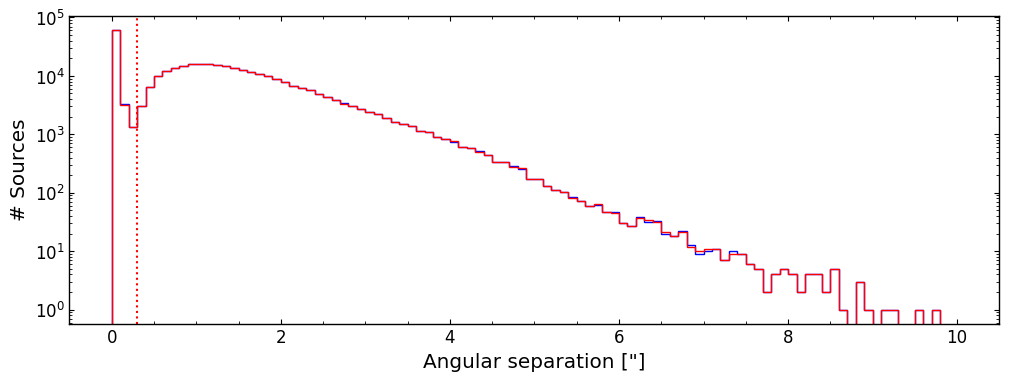

In [44]:
max_sep = 0.3*u.arcsec
phot_sersic_match = phot_sersic[d2d_sersic<max_sep]
phot_BD_match = phot_BD[d2d_BD<max_sep]
print(f"Matched sources (Sersic) : {len(phot_sersic_match)}")
print(f"Matched sources (B+D) : {len(phot_BD_match)}")

fig, ax = plt.subplots(figsize=(12,4))
ax.hist(d2d_sersic.to(u.arcsec), bins=100, range=(0*u.arcsec,10*u.arcsec), color='b', histtype='step')
ax.hist(d2d_BD.to(u.arcsec), bins=100, range=(0*u.arcsec,10*u.arcsec), color='r', histtype='step')
ax.axvline(max_sep.value, color='r', ls=':')
ax.set_yscale('log')
ax.set_xlabel('Angular separation ["]')
ax.set_ylabel('# Sources')
plt.show()

And then we match the two (Sersic and B+D) catalogs.

In [45]:
coord_sersic = SkyCoord(phot_sersic_match['world_centroid_alpha']*u.degree, phot_sersic_match['world_centroid_delta']*u.degree)
coord_BD = SkyCoord(phot_BD_match['world_centroid_alpha']*u.degree, phot_BD_match['world_centroid_delta']*u.degree)
idx, d2d, _ = coord_sersic.match_to_catalog_sky(coord_BD)
phot_sersic_match = phot_sersic_match[d2d<max_sep]
phot_BD_match = phot_BD_match[idx][d2d<max_sep]

## Clean-up

In [47]:
phot_sersic_match = phot_sersic_match[(phot_sersic_match['AXRATIO']<0.99) & 
                                      (np.abs(phot_sersic_match['SERSIC']-0.36)>1e-4) & 
                                      (phot_sersic_match['SERSIC']<8.35)&(phot_sersic_match['SERSIC']>0.301)]

phot_BD_match = phot_BD_match[(phot_BD_match['DISK_AXRATIO']<0.9999)&(phot_BD_match['DISK_AXRATIO']>0.1001)]

## Add SE++ to DJA catalogs

In [49]:
coord_dja = SkyCoord(phot_dja['ra']*u.degree, phot_dja['dec']*u.degree)
coord_sersic = SkyCoord(phot_sersic_match['world_centroid_alpha']*u.degree, phot_sersic_match['world_centroid_delta']*u.degree)
coord_BD = SkyCoord(phot_BD_match['world_centroid_alpha']*u.degree, phot_BD_match['world_centroid_delta']*u.degree)
idx_sersic, d2d_sersic, _ = coord_sersic.match_to_catalog_sky(coord_dja)
idx_BD, d2d_BD, _ = coord_BD.match_to_catalog_sky(coord_dja)

In [50]:
# Columns containing lists, to be removed
list_cols_sersic = [col for col in phot_sersic_match.colnames if phot_sersic_match.dtype[col].subdtype]
list_cols_BD = [col for col in phot_BD_match.colnames if phot_BD_match.dtype[col].subdtype]

phot_sersic_match.remove_columns(list_cols_sersic)
phot_BD_match.remove_columns(list_cols_BD)

# Remove id, ra, dec from DJA photo-z table
phot_z_dja.remove_columns(['id', 'ra', 'dec'])
phot_dja.remove_columns(['z_spec'])

In [51]:
# Creating table with as many rows as the DJA table and populating them with SE++ data
tab_sersic = Table(np.full((len(phot_dja),len(phot_sersic_match.colnames)), fill_value=np.nan), names=phot_sersic_match.colnames)
tab_sersic[idx_sersic] = phot_sersic_match

tab_BD = Table(np.full((len(phot_dja),len(phot_BD_match.colnames)), fill_value=np.nan), names=phot_BD_match.colnames)
tab_BD[idx_BD] = phot_BD_match

In [68]:
tab_dja = hstack([phot_dja, phot_z_dja], uniq_col_name='{table_name}_{col_name}', table_names=['DJA','DJA_z'])
hdu_dja = fits.BinTableHDU(tab_dja)
hdu_sersic = fits.BinTableHDU(tab_sersic)
hdu_BD = fits.BinTableHDU(tab_BD)
hdul = fits.HDUList([fits.PrimaryHDU(), hdu_dja, hdu_sersic, hdu_BD])

In [69]:
# Save catalog
hdul.writeto(f"{home}/fields/{field}/catalog/{field}_morpho-phot.fits.gz", overwrite=True) # Compressed
# hdul.writeto(f"{home}/fields/{field}/catalog/{field}_morpho-phot.fits", overwrite=True) # Un-compressed

In [70]:
# Read FITS catalog
with fits.open(f"{home}/fields/{field}/catalog/{field}_morpho-phot.fits.gz") as hdul:
    tab_dja = Table(hdul[1].data)
    tab_sersic = Table(hdul[2].data)
    tab_BD = Table(hdul[3].data)

In [82]:
len_dja = len(tab_dja)
len_sersic = len(tab_sersic[~np.isnan(tab_sersic['SERSIC'])])
len_BD = len(tab_BD[~np.isnan(tab_BD['DISK_AXRATIO'])])
len_sersic_BD = len(tab_dja[~np.isnan(tab_sersic['SERSIC']) & ~np.isnan(tab_BD['DISK_AXRATIO'])])
print(f"{'DJA sources':<27} : {len_dja}")
print(f"{'Sérsic fitted sources':<27} : {len_sersic} ({len_sersic/len_dja*100:.1f}%)")
print(f"{'B+D fitted sources':<27} : {len_BD} ({len_BD/len_dja*100:.1f}%)")
print(f"{'Sérsic & B+D fitted sources':<27} : {len_sersic_BD} ({len_sersic_BD/len_dja*100:.1f}%)")

DJA sources                 : 76637
Sérsic fitted sources       : 57878 (75.5%)
B+D fitted sources          : 64525 (84.2%)
Sérsic & B+D fitted sources : 56798 (74.1%)


## Plots

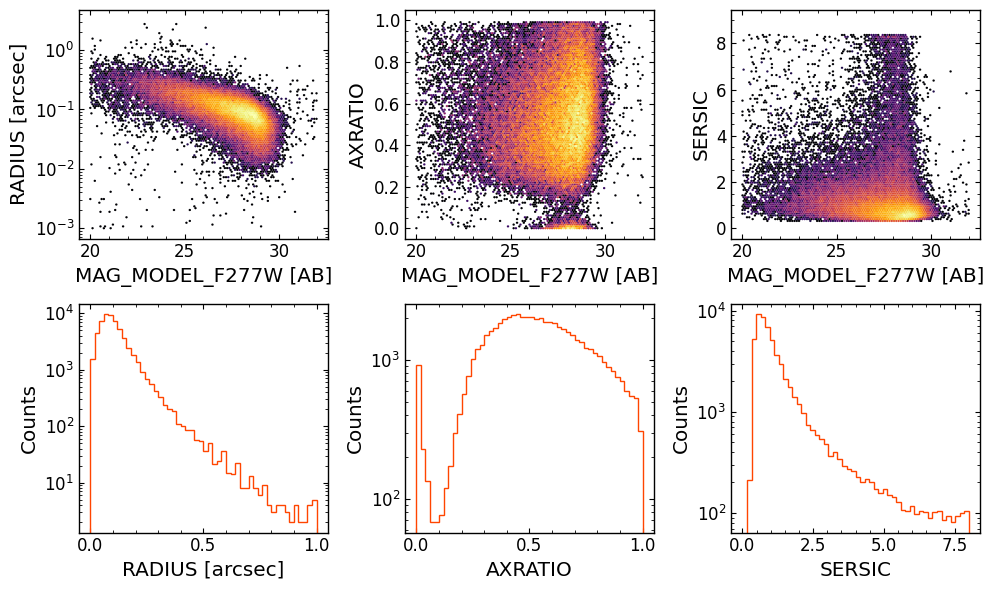

In [71]:
# sersic_rg4

filter = 'f277w'
fig, axs = plt.subplots(2,3, figsize=(10,6))

axs[0,0].hexbin(tab_sersic[f'MAG_MODEL_{filter.upper()}'], tab_sersic['RADIUS']*3600, mincnt=1, gridsize=100, cmap='inferno', bins='log', yscale='log', extent=(20,32,-3,0.5), lw=0.01)
axs[0,0].set_xlabel(f"MAG_MODEL_{filter.upper()} [AB]")
axs[0,0].set_ylabel("RADIUS [arcsec]")

axs[0,1].hexbin(tab_sersic[f'MAG_MODEL_{filter.upper()}'], tab_sersic['AXRATIO'], mincnt=1, gridsize=100, cmap='inferno', bins='log', extent=(20,32,0,1), lw=0.01)
axs[0,1].set_xlabel(f"MAG_MODEL_{filter.upper()} [AB]")
axs[0,1].set_ylabel("AXRATIO")

axs[0,2].hexbin(tab_sersic[f'MAG_MODEL_{filter.upper()}'], tab_sersic['SERSIC'], mincnt=1, gridsize=100, cmap='inferno', bins='log', extent=(20,32,0,9), lw=0.01)
axs[0,2].set_xlabel(f"MAG_MODEL_{filter.upper()} [AB]")
axs[0,2].set_ylabel("SERSIC")

axs[1,0].hist(tab_sersic['RADIUS']*3600, bins=50, range=(0,1), histtype='step', log=True, color='orangered')
axs[1,0].set_xlabel("RADIUS [arcsec]")
axs[1,0].set_ylabel("Counts")

axs[1,1].hist(tab_sersic['AXRATIO'], bins=50, range=(0,1), histtype='step', log=True, color='orangered')
axs[1,1].set_xlabel("AXRATIO")
axs[1,1].set_ylabel("Counts")

axs[1,2].hist(tab_sersic['SERSIC'], bins=50, range=(0,8), histtype='step', log=True, color='orangered')
axs[1,2].set_xlabel("SERSIC")
axs[1,2].set_ylabel("Counts")

fig.tight_layout()
# fig.savefig(f"{home}/fields/{field}/sepp/{field}-sersic_rg4_morphology.pdf", bbox_inches='tight')
# fig.savefig(f"{home}/fields/{field}/sepp/{field}-sersic_rg4_morphology.png", bbox_inches='tight', dpi=200)
plt.show()

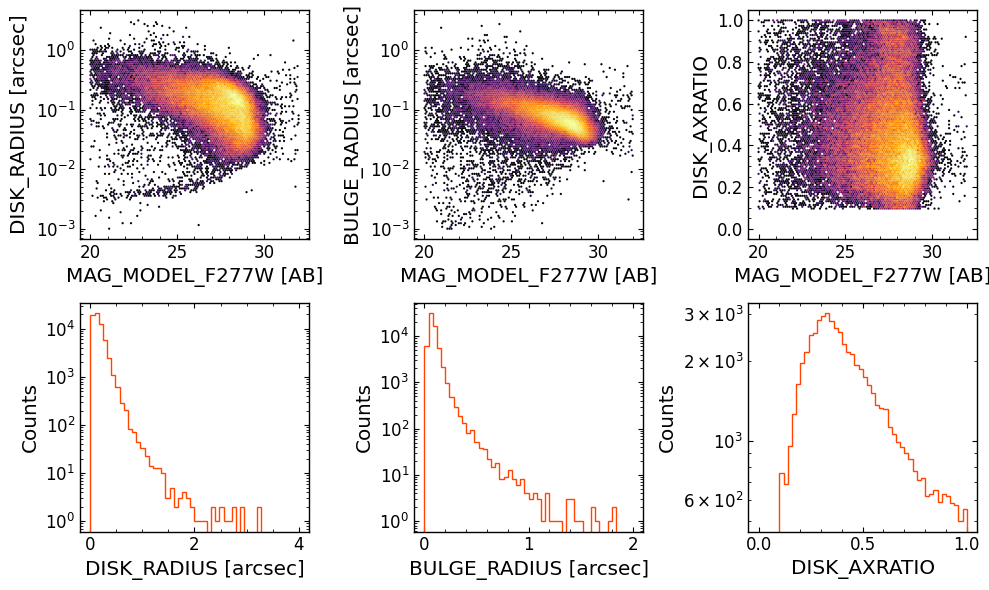

In [72]:
# B+D

filter = 'f277w'
fig, axs = plt.subplots(2,3, figsize=(10,6))

axs[0,0].hexbin(tab_BD[f'MAG_MODEL_{filter.upper()}'], tab_BD['DISK_RADIUS_deg']*3600, mincnt=1, gridsize=100, cmap='inferno', bins='log', yscale='log', extent=(20,32,-3,0.5), lw=0.01)
axs[0,0].set_xlabel(f"MAG_MODEL_{filter.upper()} [AB]")
axs[0,0].set_ylabel("DISK_RADIUS [arcsec]")

axs[0,1].hexbin(tab_BD[f'MAG_MODEL_{filter.upper()}'], tab_BD['BULGE_RADIUS_deg']*3600, mincnt=1, gridsize=100, cmap='inferno', bins='log', yscale='log', extent=(20,32,-3,0.5), lw=0.01)
axs[0,1].set_xlabel(f"MAG_MODEL_{filter.upper()} [AB]")
axs[0,1].set_ylabel("BULGE_RADIUS [arcsec]")

axs[0,2].hexbin(tab_BD[f'MAG_MODEL_{filter.upper()}'], tab_BD['DISK_AXRATIO'], mincnt=1, gridsize=100, cmap='inferno', bins='log', extent=(20,32,0,1), lw=0.01)
axs[0,2].set_xlabel(f"MAG_MODEL_{filter.upper()} [AB]")
axs[0,2].set_ylabel("DISK_AXRATIO")

axs[1,0].hist(tab_BD['DISK_RADIUS_deg']*3600, bins=50, range=(0,4), histtype='step', log=True, color='orangered')
axs[1,0].set_xlabel("DISK_RADIUS [arcsec]")
axs[1,0].set_ylabel("Counts")

axs[1,1].hist(tab_BD['BULGE_RADIUS_deg']*3600, bins=50, range=(0,2), histtype='step', log=True, color='orangered')
axs[1,1].set_xlabel("BULGE_RADIUS [arcsec]")
axs[1,1].set_ylabel("Counts")

axs[1,2].hist(tab_BD['DISK_AXRATIO'], bins=50, range=(0,1), histtype='step', log=True, color='orangered')
axs[1,2].set_xlabel("DISK_AXRATIO")
axs[1,2].set_ylabel("Counts")

fig.tight_layout()
# fig.savefig(f"{home}/fields/{field}/sepp/{field}-B+D_morphology.pdf", bbox_inches='tight')
# fig.savefig(f"{home}/fields/{field}/sepp/{field}-B+D_morphology.png", bbox_inches='tight', dpi=200)
plt.show()

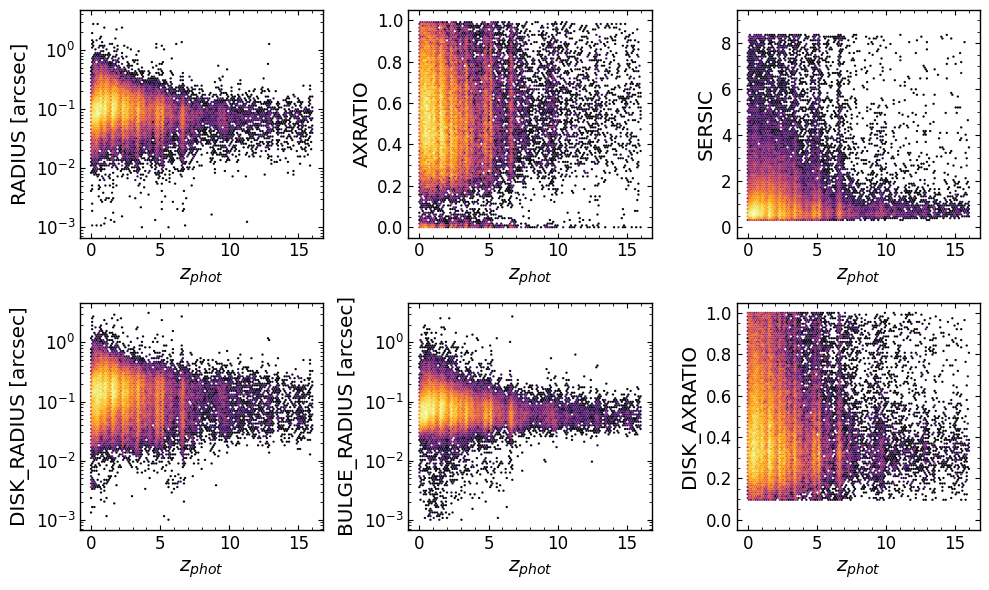

In [73]:
fig, axs = plt.subplots(2,3, figsize=(10,6))

axs[0,0].hexbin(tab_dja['z_phot'], tab_sersic['RADIUS']*3600, mincnt=1, gridsize=100, cmap='inferno', bins='log', yscale='log', extent=(0,16,-3,0.5), lw=0.01)
axs[0,0].set_xlabel(r"$z_{phot}$")
axs[0,0].set_ylabel("RADIUS [arcsec]")

axs[0,1].hexbin(tab_dja['z_phot'], tab_sersic['AXRATIO'], mincnt=1, gridsize=100, cmap='inferno', bins='log', extent=(0,16,0,1), lw=0.01)
axs[0,1].set_xlabel(r"$z_{phot}$")
axs[0,1].set_ylabel("AXRATIO")

axs[0,2].hexbin(tab_dja['z_phot'], tab_sersic['SERSIC'], mincnt=1, gridsize=100, cmap='inferno', bins='log', extent=(0,16,0,9), lw=0.01)
axs[0,2].set_xlabel(r"$z_{phot}$")
axs[0,2].set_ylabel("SERSIC")

axs[1,0].hexbin(tab_dja['z_phot'], tab_BD['DISK_RADIUS_deg']*3600, mincnt=1, gridsize=100, cmap='inferno', bins='log', yscale='log', extent=(0,16,-3,0.5), lw=0.01)
axs[1,0].set_xlabel(r"$z_{phot}$")
axs[1,0].set_ylabel("DISK_RADIUS [arcsec]")

axs[1,1].hexbin(tab_dja['z_phot'], tab_BD['BULGE_RADIUS_deg']*3600, mincnt=1, gridsize=100, cmap='inferno', bins='log', yscale='log', extent=(0,16,-3,0.5), lw=0.01)
axs[1,1].set_xlabel(r"$z_{phot}$")
axs[1,1].set_ylabel("BULGE_RADIUS [arcsec]")

axs[1,2].hexbin(tab_dja['z_phot'], tab_BD['DISK_AXRATIO'], mincnt=1, gridsize=100, cmap='inferno', bins='log', extent=(0,16,0,1), lw=0.01)
axs[1,2].set_xlabel(r"$z_{phot}$")
axs[1,2].set_ylabel("DISK_AXRATIO")

fig.tight_layout()
# fig.savefig(f"{home}/fields/{field}/sepp/{field}-B+D_morphology.pdf", bbox_inches='tight')
# fig.savefig(f"{home}/fields/{field}/sepp/{field}-B+D_morphology.png", bbox_inches='tight', dpi=200)
plt.show()

In [74]:
snr_cond = (~np.isnan(tab_sersic['snrratio'])) & (tab_sersic['snrratio']>100) & (tab_sersic['MAG_MODEL_F277W']<28)
mass_cond = tab_dja['mass']>1e9

/tmp/ipykernel_8207/892877644.py:8: RuntimeWarning: invalid value encountered in log10
  uv = -2.5*np.log10(tab_dja[cond]['restU']/tab_dja[cond]['restV'])
/tmp/ipykernel_8207/892877644.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=(0,0,0.85,1))


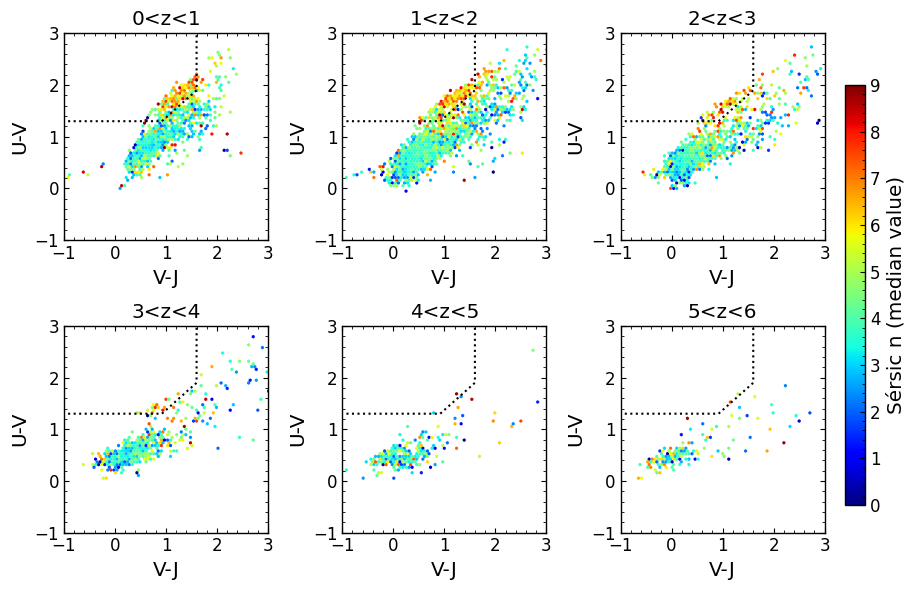

In [75]:
fig, axs = plt.subplots(2,3, figsize=(10,6))

for i in range(6):
    z = (i, i+1)
    ax = axs.flatten()[i]
    z_cond = (tab_dja['z_phot']>z[0])&(tab_dja['z_phot']<z[1])
    cond = snr_cond & mass_cond & z_cond
    uv = -2.5*np.log10(tab_dja[cond]['restU']/tab_dja[cond]['restV'])
    vj = -2.5*np.log10(tab_dja[cond]['restV']/tab_dja[cond]['restJ'])
    ax.plot([-2,0.92,1.6,1.6], [1.3,1.3,1.898,4], ls=':', c='k')
    ax.hexbin(x=vj, y=uv, C=tab_sersic[cond]['SERSIC'], reduce_C_function=np.median,
              mincnt=1, gridsize=100, cmap='jet', bins='log', extent=(-2,4,-2,4), lw=0.01, vmax=9)
    ax.set_xlim(-1,3)
    ax.set_ylim(-1,3)
    ax.set_title(f"{z[0]}<z<{z[1]}")
    ax.set_xlabel("V-J")
    ax.set_ylabel("U-V")

cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
norm = mpl.colors.Normalize(vmin=0,vmax=9)
sm = plt.cm.ScalarMappable(cmap=plt.get_cmap('jet'), norm=norm)
sm.set_array([])
fig.colorbar(sm, ticks=np.linspace(0,9,10), cax=cbar_ax, label='Sérsic n (median value)')

fig.tight_layout(rect=(0,0,0.85,1))
# fig.savefig(f"{home}/fields/{field}/sepp/{field}-B+D_morphology.pdf", bbox_inches='tight')
# fig.savefig(f"{home}/fields/{field}/sepp/{field}-B+D_morphology.png", bbox_inches='tight', dpi=200)
plt.show()

In [76]:
mass_cond = tab_dja['mass']>1e10
len(tab_dja[snr_cond & mass_cond])

2042

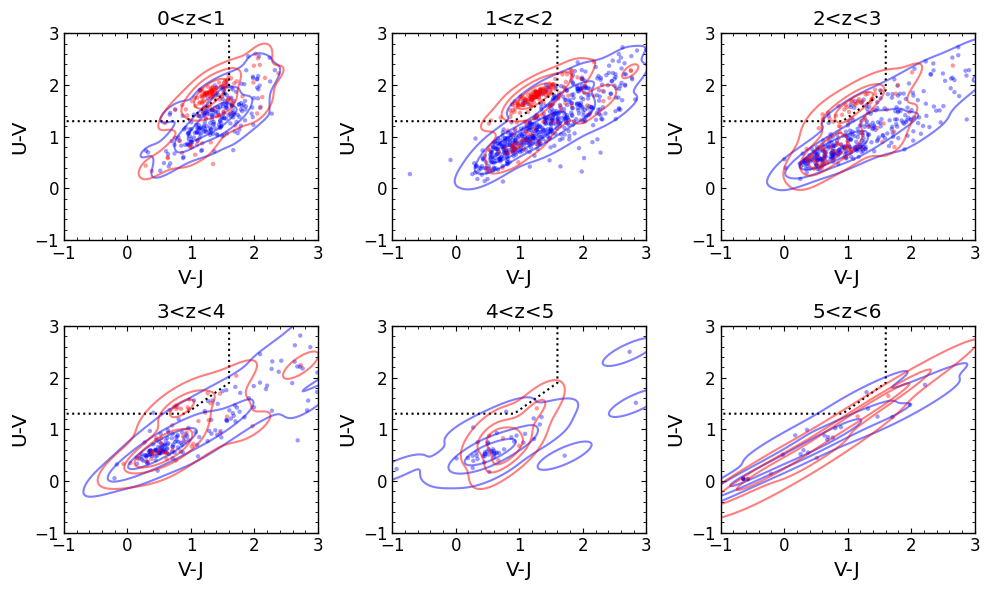

In [77]:
fig, axs = plt.subplots(2,3, figsize=(10,6))

for i in range(6):
    z = (i, i+1)
    ax = axs.flatten()[i]
    z_cond = (tab_dja['z_phot']>z[0])&(tab_dja['z_phot']<z[1])
    cond = snr_cond & mass_cond & z_cond
    uv = -2.5*np.log10(tab_dja[cond]['restU']/tab_dja[cond]['restV'])
    vj = -2.5*np.log10(tab_dja[cond]['restV']/tab_dja[cond]['restJ'])
    disk = (tab_sersic[cond]['SERSIC']<4)&(tab_BD[cond]['B/T_F200W']<0.4)
    bulge = (tab_sersic[cond]['SERSIC']>1)&(tab_BD[cond]['B/T_F200W']>0.5)
    ax.plot([-2,0.92,1.6,1.6], [1.3,1.3,1.898,4], ls=':', c='k')
    ax.scatter(vj[disk], uv[disk], c='b', alpha=0.4, s=10, ec='none')
    sns.kdeplot(x=vj[disk], y=uv[disk], ax=ax, levels=4, color='b', alpha=0.5)
    ax.scatter(vj[bulge], uv[bulge], c='r', alpha=0.4, s=10, ec='none')
    sns.kdeplot(x=vj[bulge], y=uv[bulge], ax=ax, levels=4, color='r', alpha=0.5)
    ax.set_xlim(-1,3)
    ax.set_ylim(-1,3)
    ax.set_title(f"{z[0]}<z<{z[1]}")
    ax.set_xlabel("V-J")
    ax.set_ylabel("U-V")

fig.tight_layout()
# fig.savefig(f"{home}/fields/{field}/sepp/{field}-B+D_morphology.pdf", bbox_inches='tight')
# fig.savefig(f"{home}/fields/{field}/sepp/{field}-B+D_morphology.png", bbox_inches='tight', dpi=200)
plt.show()

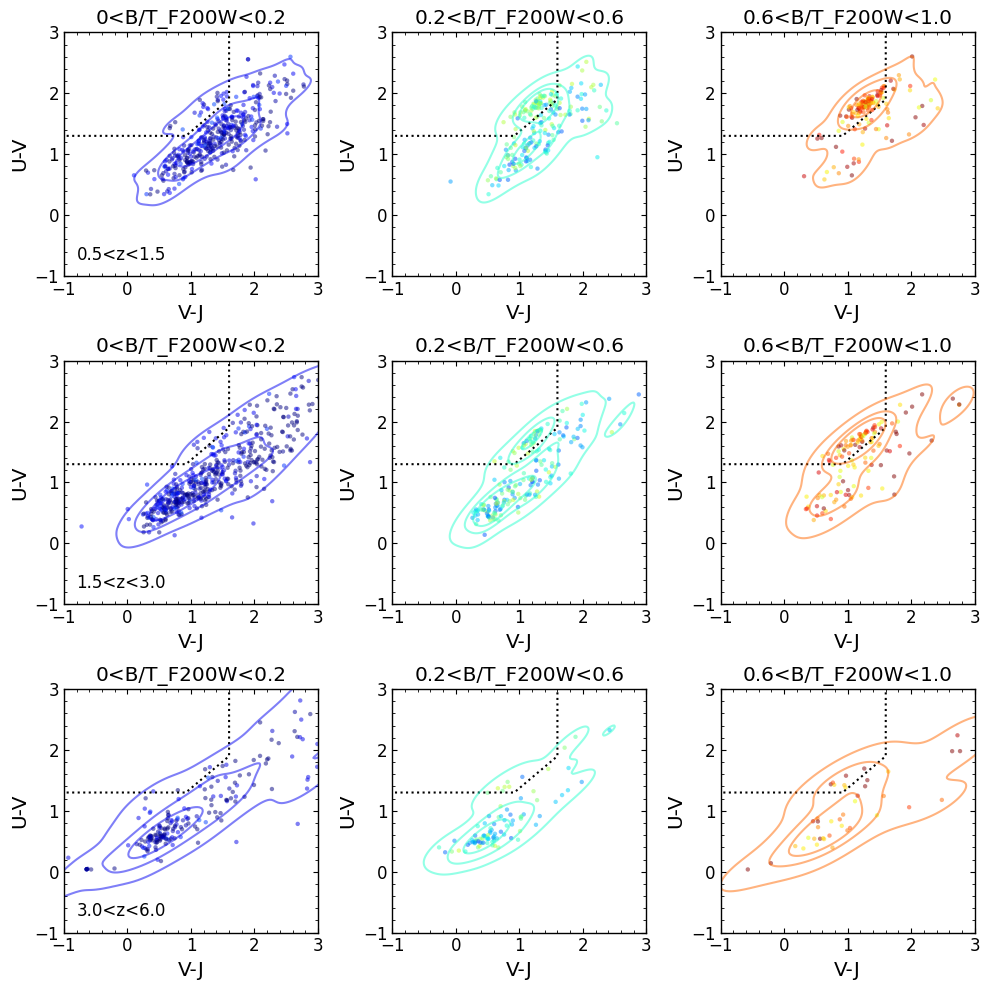

In [78]:
fig, axs = plt.subplots(3,3, figsize=(10,10))

Z = [(0.5,1.5),(1.5,3),(3,6)]
BT = [(0,0.2), (0.2,0.6), (0.6,1.0)]

for i in range(3):
    z = Z[i]
    z_cond = (tab_dja['z_phot']>z[0])&(tab_dja['z_phot']<z[1])
    for j in range(3):
        ax = axs[i,j]
        bt = BT[j]
        BT_cond = (tab_BD['B/T_F200W']>bt[0])&(tab_BD['B/T_F200W']<bt[1])
        cond = snr_cond & mass_cond & z_cond & BT_cond
        uv = -2.5*np.log10(tab_dja[cond]['restU']/tab_dja[cond]['restV'])
        vj = -2.5*np.log10(tab_dja[cond]['restV']/tab_dja[cond]['restJ'])
        ax.plot([-2,0.92,1.6,1.6], [1.3,1.3,1.898,4], ls=':', c='k')
        ax.scatter(vj, uv, c=tab_BD[cond]['B/T_F200W'], alpha=0.5, s=10, ec='none', vmin=0, vmax=1, cmap='jet')
        sns.kdeplot(x=vj, y=uv, ax=ax, levels=4, color=mpl.colormaps.get_cmap('jet')(0.5*(bt[0]+bt[1])), alpha=0.5)
        ax.set_xlim(-1,3)
        ax.set_ylim(-1,3)
        ax.set_title(f"{bt[0]}<B/T_F200W<{bt[1]}")
        ax.set_xlabel("V-J")
        ax.set_ylabel("U-V")
        if j==0: ax.text(0.05, 0.05, f"{z[0]:.1f}<z<{z[1]:.1f}", transform=ax.transAxes, ha='left', va='bottom', fontsize='large')

fig.tight_layout()
# fig.savefig(f"{home}/fields/{field}/sepp/{field}-B+D_morphology.pdf", bbox_inches='tight')
# fig.savefig(f"{home}/fields/{field}/sepp/{field}-B+D_morphology.png", bbox_inches='tight', dpi=200)
plt.show()